# 血糖値　分類

In [1]:
%load_ext autoreload

%autoreload 2
import time

import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy
import os
import glob
import sys
from pathlib import Path

import matplotlib.pyplot as plt

In [59]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [60]:
import easy_chainer

In [4]:
front_list = sorted(glob.glob("C:/Users/Owner/Desktop/LAB/LAB 2019/analysis/mix_fabric/CP*F*"))
back_list = sorted(glob.glob("C:/Users/Owner/Desktop/LAB/LAB 2019/analysis/mix_fabric/CP*B*"))

In [19]:
xls = pandas.read_excel("C:/Users/Owner/Desktop/blood_glucose.xls")

In [6]:
cp_list = sorted(glob.glob("C:/Users/Owner/Desktop/LAB/LAB 2019/analysis/mix_fabric/CP*.txt"))


In [5]:
xls = pandas.read_csv(front_list[0], skiprows=4, delimiter="\t", header=None)
col = xls.as_matrix()[:,0]

j = 0
for list_ in (front_list, back_list):
#     print(list_)
    for i, fname in enumerate (list_):
        xls = pandas.read_csv(fname, comment="#", delimiter="\t", header=None)
        if j == 0:
            arr = xls.as_matrix()[:,1]
            hddr = os.path.split(fname)[1].split(".")[0]
        else:
            arr = numpy.vstack((arr, xls.as_matrix()[:,1]))
            hddr = numpy.hstack((hddr, os.path.split(fname)[1].split(".")[0]))
        j += 1

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [6]:
print(arr.shape, col.shape, hddr.shape)

(1249, 1713) (1713,) (1249,)


In [7]:
front_list[0:1]

['C:/Users/Owner/Desktop/LAB/LAB 2019/analysis/mix_fabric\\CP01F1.txt']

In [4]:
data, teach = easy_chainer.load_Data("C:/Users/Owner/Desktop/blood_glucose.xls")
data = data.astype(numpy.float32)
teach = teach
print(teach)

[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4.
 4. 4. 0. 0. 1. 1. 2. 2. 3. 3. 4. 4.]


C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = xls.as_matrix()[:-1]
C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  teach = xls.as_matrix()[-1]


In [5]:
teach = teach.astype(numpy.int8)
teach_bins = numpy.histogram(teach, bins=numpy.max(teach) + 1)
teach_bins

(array([ 9, 11, 16, 16,  8], dtype=int64),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]))

In [ ]:
k = 7


for i in range(int(max(teach) + 1)):
    tmp0_arr = numpy.where(teach == i)[0]
    try:
        tmp0 = numpy.random.choice(tmp0_arr, int(k), replace=False)
        if i == 0:
            id_train = tmp0
        else:
            id_train = numpy.hstack((id_train, tmp0))
    except Exception:
        print("Not teach")

In [39]:
import random

In [13]:
teach[10:]

array([ 3.,  2.,  2.,  3.,  0.,  2.,  3.,  1.,  2.,  2.,  1.,  2.,  4.,
        0.,  0.,  0.,  4.,  0.,  1.,  1.,  1.,  3.,  1.,  3.,  4.,  3.,
        4.,  3.,  3.,  0.,  3.,  3.,  2.,  3.,  3.,  1.,  2.,  2.,  0.,
        1.,  2.,  3.,  2.,  1.,  4.,  0.,  4.,  1.,  2.,  2., nan, nan],
      dtype=float32)

In [6]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1
print(id_all)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [7]:
id_train = numpy.random.choice(id_all, 50, replace=False) #重複なし
print(id_train)

[44 10 29 16 40  5 25 13 48 50  1  8 51 22 45  3 56 32 17  4 31 26 27 58
 33 47 35 28 20  2  7 36 15 18 38 21 54 41 59  9 23 43 24 11  0 39 30 34
 19 55]


In [36]:
teach = teach.astype(numpy.int32)

In [8]:
id_test = numpy.delete(id_all, id_train)
print(id_test)

[ 6 12 14 37 42 46 49 52 53 57]


In [9]:
x_train, y_train = data[:, id_train], teach[id_train]
x_test, y_test = data[:, id_test], teach[id_test]

In [17]:
y_train

array([80.9, 82.2, 48.2, 63. , 53.1, 32.1, 20. , 22.3, 20.7, 80.7, 45.2,
       63.9, 66. , 63.9, 82.8, 82.5, 65.7, 15.3, 85.2, 79.5, 21.9, 83.2,
       27.4, 65.7, 68.4, 36. , 65.8, 20.2, 65.6, 62. , 63.7, 64.6, 83.3,
       81.9, 83.9, 81.5, 70.4, 19.9, 84.2,  9. , 37.6, 65.6, 66.5, 63.6,
       61.2, 19.4, 63. , 91.6, 82.7, 32.3, 66.3, 76.7, 65.6, 49.6, 53.8,
       81.6, 77.8,  0.4, 47.2, 21.2, 69.6, 81.2, 63.4, 65.8, 83.1, 81.9,
       82.6, 78.5, 82.3, 62.5, 83.5, 42.4, 82.2, 83.4, 77.9, 78.1, 65.4,
       66. , 82.4, 66.4, 90.5, 38.3, 62.3, 63.8, 64.3, 62.3, 62.9, 61.3,
       27.9, 20.2, 50.3, 62.1, 62.5, 50.3, 91.2, 65.6, 79.6, 64.4, 72.6,
       55.3], dtype=float32)

In [10]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1, ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, ))

train_iter = chainer.iterators.SerialIterator(train, 50)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

In [ ]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1, ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, ))

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 27, repeat=False, shuffle=False)

In [11]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [18]:
model = L.Classifier(MLP(1000,1),
                     lossfun=F.mean_squared_error,
                     accfun=F.r2_score)
model.compute_accuracy = False

In [ ]:
model = (MLP(1000,1)
loss = F.mean_square_error(model(x_train),y_train)
accfun = F.r2_score

In [12]:
# 分類に使う
net = MLP(1000, 5)
model = L.Classifier(net)

In [13]:
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

In [14]:
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (500, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

In [15]:
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [16]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.56203     1.79455               0.32           0                         0.112681      
2           1.54656     1.78719               0.32           0                         1.11974       
3           1.53862     1.78434               0.32           0                         1.45918       
4           1.5339      1.78277               0.32           0                         1.80933       
5           1.53044     1.78261               0.32           0                         2.12157       
6           1.52752     1.7809                0.32           0                         2.45649       
7           1.52483     1.77956               0.32           0                         2.78914       
8           1.52245     1.77824               0.32           0                         3.11816       
9           1.52051     1.77698               0.32           0                      

81          1.45224     1.73404               0.34           0                         28.31         
82          1.4514      1.73351               0.34           0                         28.7493       
83          1.45057     1.73286               0.36           0                         29.1102       
84          1.44974     1.73203               0.36           0                         29.4334       
85          1.4489      1.73167               0.36           0                         29.7681       
86          1.44807     1.73107               0.36           0                         30.1093       
87          1.44724     1.73089               0.36           0                         30.4687       
88          1.44639     1.73001               0.36           0                         30.8359       
89          1.44556     1.72947               0.36           0                         31.1673       
90          1.44473     1.72907               0.36           0                    

159         1.38668     1.68973               0.42           0.1                       55.7203       
160         1.38586     1.68935               0.42           0.1                       56.0658       
161         1.38504     1.68882               0.42           0.1                       56.4787       
162         1.3842      1.68826               0.42           0.1                       56.8356       
163         1.38336     1.68781               0.42           0.1                       57.1678       
164         1.38251     1.68721               0.42           0.1                       57.5303       
165         1.38168     1.68651               0.44           0.1                       57.8593       
166         1.38086     1.68621               0.44           0.1                       58.1768       
167         1.38004     1.68555               0.44           0.1                       58.5185       
168         1.37923     1.68487               0.44           0.1                  

237         1.32741     1.64716               0.46           0.2                       82.0154       
238         1.32674     1.64682               0.46           0.2                       82.3373       
239         1.32608     1.64594               0.46           0.2                       82.6795       
240         1.32542     1.64561               0.46           0.2                       83.0248       
241         1.32476     1.64519               0.46           0.2                       83.3454       
242         1.32411     1.64457               0.46           0.2                       83.6697       
243         1.32344     1.64397               0.46           0.2                       84.0024       
244         1.32278     1.64336               0.46           0.2                       84.3261       
245         1.32214     1.64324               0.46           0.2                       84.66         
246         1.32151     1.64249               0.46           0.2                  

315         1.28405     1.61113               0.48           0.2                       109.034       
316         1.28359     1.61064               0.48           0.2                       109.377       
317         1.28314     1.61012               0.48           0.2                       109.743       
318         1.2827      1.61001               0.48           0.2                       110.093       
319         1.28226     1.60968               0.48           0.2                       110.428       
320         1.28181     1.60913               0.48           0.2                       110.769       
321         1.28137     1.60886               0.48           0.2                       111.114       
322         1.28093     1.60818               0.48           0.2                       112.021       
323         1.28049     1.60792               0.48           0.2                       112.354       
324         1.28006     1.60754               0.48           0.2                  

396         1.25422     1.58126               0.5            0.2                       140.401       
397         1.25393     1.58133               0.5            0.2                       140.786       
398         1.25364     1.58059               0.5            0.2                       141.152       
399         1.25335     1.58064               0.5            0.2                       142.265       
400         1.25307     1.57974               0.5            0.2                       142.685       
     total [########################################..........] 80.00%
this epoch [..................................................]  0.00%
       400 iter, 400 epoch / 500 epochs
    2.7841 iters/sec. Estimated time to finish: 0:00:35.918257.
401         1.25278     1.58021               0.5            0.2                       143.086       
402         1.25251     1.57923               0.5            0.2                       143.474       
403         1.25223     1.5793          

474         1.23478     1.55781               0.5            0.2                       169.539       
475         1.23457     1.55794               0.5            0.2                       169.878       
476         1.23436     1.55737               0.5            0.2                       170.229       
477         1.23415     1.55717               0.5            0.2                       170.569       
478         1.23393     1.55717               0.5            0.2                       170.905       
479         1.23373     1.55702               0.5            0.2                       171.289       
480         1.23351     1.55651               0.5            0.2                       171.657       
481         1.23329     1.55611               0.5            0.2                       172.018       
482         1.23308     1.55616               0.5            0.2                       172.388       
483         1.23287     1.55571               0.5            0.2                  

In [17]:
import pandas
import glob
import os
import sys
import csv
import numpy

In [4]:
csv = pandas.read_csv("C:/Users/Owner/Desktop/[190611]kurasawa/Blood_glucose_level/1.csv", header=None)

f = open("C:/Users/Owner/Desktop/[190611]kurasawa/Blood_glucose_level/1.csv","r")
csv_list = []
csv_list.append(csv)

print(csv.shape)


(195609, 3)


# 血糖値　回帰予測

In [73]:
%load_ext autoreload

%autoreload 2
import time

import pandas
import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


from chainer.datasets import tuple_dataset
from chainer.dataset import convert, concat_examples

import numpy
import os
import glob
import sys
from pathlib import Path

from chainer import Sequential
import easy_chainer

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out
            
           
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [74]:
# 5層以上NN
# Batch Normalization
class MLP2(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP2, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_units)  # n_units -> n_units
            self.l4 = L.Linear(None, n_units)    # n_units -> n_out
            self.l5 = L.Linear(None, n_out)


    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        dh = F.dropout(h1, 0.8)                       # batch normalization層を作る（試験的に導入,検討を重ねる必要がある）
        h2 = F.relu(self.l2(h1))
        h = F.dropout(h2, 0.5)                       # batch normalization
        h3 = F.relu(self.l3(h2))
        kh = F.dropout(h3, 0.2)                      # batch normalization
        h4 = F.relu(self.l4(h3))
        return self.l5(h4)

In [75]:
data, teach = easy_chainer.load_Data("C:/Users/Owner/Desktop/Normalized/blood_glucose_fulldata.xlsx")
data = data.astype(numpy.float32)

print(teach.shape)
print(data.shape)

(427,)
(1000, 427)


C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = xls.as_matrix()[:-1]
C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  teach = xls.as_matrix()[-1]


In [76]:
print(data.shape)

(1000, 427)


In [77]:
teach = teach.astype(numpy.float32)

In [45]:
id_all = numpy.arange(1, len(teach) + 1, 1).astype(numpy.int32) - 1


In [44]:
numpy.random.seed(32)
id_train = numpy.random.choice(id_all, 300, replace=False) #重複なし


In [43]:
id_test = numpy.delete(id_all, id_train)


In [14]:
teach[id_test]

array([ 97.,  89., 150., 134., 145.,  98.,  94.,  98., 102.,  90., 137.,
       139., 141., 151., 133., 144., 116., 109., 111., 111., 116., 117.,
       128., 121., 156., 179., 154., 145., 149., 149., 157., 160., 135.,
       133., 134., 114.,  98., 109., 118., 143., 135., 149., 153., 132.,
       132., 120.,  90.,  96.,  95.,  96.,  96., 158., 145., 156., 141.,
       120., 128., 132.,  95.,  98., 113., 113., 131., 137., 142., 104.,
       161., 164., 167., 186., 188., 189., 156., 167., 137., 140., 151.,
        94., 103.,  82., 169., 173., 168., 191., 147., 152., 155., 158.,
       128., 131., 100.,  99., 177., 154., 143., 125., 117., 129., 145.,
       149., 145., 100.,  96.,  99., 108.,  95.,  97.,  95., 185., 182.,
       180., 162., 169., 154., 131., 127., 125., 133., 145., 117., 114.,
       185., 210., 190., 204., 220., 180.], dtype=float32)

In [11]:
print(id_train.shape, id_test.shape)

(400,) (28,)


In [46]:
id_train_1 = teach[0:394]
id_test_1 = teach[394:427]

id_train = id_train_1.astype(numpy.int32)
id_test = id_test_1.astype(numpy.int32)

# teach = teach.astype(numpy.float32)

# print("id_train : ", id_train)
print("id_train : ", id_train.shape)
print("id_train_type : ", id_train.dtype)

# print("id_test : ", id_test)
print("id_test : ", id_test.shape)
print("id_test : ", id_test.dtype)

id_train :  (394,)
id_train_type :  int32
id_test :  (33,)
id_test :  int32


In [47]:
x_train, y_train = data[:, id_train], teach[id_train]
x_test, y_test = data[:, id_test], teach[id_test]

In [48]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

train_iter = chainer.iterators.SerialIterator(train, 10, repeat=True, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

In [49]:
net = MLP2(1000,1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun = F.r2_score)
model.compute_accuracy = False

In [50]:
#optimizer = chainer.optimizers.SGD()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [25]:
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (500, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

In [51]:
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (20, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

In [52]:
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [53]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1762.83     1181.99                                                        5.0672        
2           690.236     867.108                                                        9.96964       
     total [######............................................] 12.69%
this epoch [##########################........................] 53.81%
       100 iter, 2 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
3           683.935     855.176                                                        14.938        
4           603.466     511.949                                                        19.7251       
5           536.636     448.725                                                        24.5303       
     total [############......................................] 25.38%
this epoch [###...............................................]  7.61%
       200 i

In [29]:
# test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = numpy.argmax(net(test_spc[i].reshape(1, -1)).data)
    print("Ref: %d, Pred: %d id_test: %s" % (ref, pred))


Ref: 188, Pred: 0 id_test: 188
Ref: 189, Pred: 0 id_test: 199
Ref: 156, Pred: 0 id_test: 371
Ref: 167, Pred: 0 id_test: 214
Ref: 137, Pred: 0 id_test: 140
Ref: 140, Pred: 0 id_test: 39
Ref: 151, Pred: 0 id_test: 63
Ref: 94, Pred: 0 id_test: 19
Ref: 103, Pred: 0 id_test: 296
Ref: 82, Pred: 0 id_test: 146


In [32]:
test_ref[1]

array([111.], dtype=float32)

In [51]:
net(test_spc[0].reshape(1, -1)).data

array([[159.69165]], dtype=float32)

In [28]:
test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))


Ref: 97, Pred: 100 [[False]]
Ref: 222, Pred: 187 [[False]]
Ref: 109, Pred: 115 [[False]]
Ref: 165, Pred: 184 [[False]]
Ref: 205, Pred: 164 [[False]]
Ref: 172, Pred: 193 [[False]]
Ref: 167, Pred: 148 [[False]]
Ref: 142, Pred: 151 [[False]]
Ref: 160, Pred: 153 [[False]]
Ref: 103, Pred: 102 [[False]]


In [29]:
arr_train = numpy.array([97, 222, 109, 165, 205, 172, 167, 142, 160, 103])
arr_test = numpy.array([100, 187, 115, 184, 164, 193, 148, 151, 153, 102])

In [30]:
import matplotlib.pyplot as plt

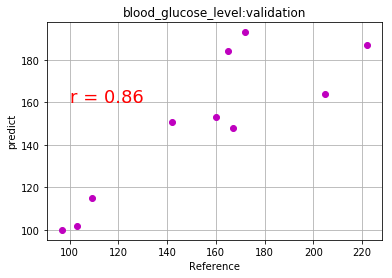

In [32]:
plt.plot(arr_train, arr_test, 'mo')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:validation')
plt.text(100,160, 'r = 0.86', fontsize=18, color='r')
plt.savefig('val_result')
plt.show()

In [31]:
cor = numpy.corrcoef(arr_train, arr_test)[0, 1]
print(cor)

0.8648281590142726


In [33]:
train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    ref = train_ref[i]
    pred = net(train_spc[i].reshape(1, -1)).data
    print("Ref: %d, Pred: %d %s" % (ref, pred, ref == pred))


Ref: 169, Pred: 179 [[False]]
Ref: 97, Pred: 88 [[False]]
Ref: 103, Pred: 121 [[False]]
Ref: 188, Pred: 182 [[False]]
Ref: 203, Pred: 179 [[False]]
Ref: 160, Pred: 160 [[False]]
Ref: 129, Pred: 138 [[False]]
Ref: 150, Pred: 167 [[False]]
Ref: 119, Pred: 144 [[False]]
Ref: 111, Pred: 116 [[False]]


In [30]:
tarr_ref = numpy.array([169, 97, 103, 188, 203, 160, 129, 150, 119, 111])
tarr_pre = numpy.array([179, 88, 121, 182, 179, 154, 114, 97, 101, 110])
print(tarr_ref.shape, tarr_pre.shape)

(10,) (10,)


In [31]:
tcor = numpy.corrcoef(tarr_ref, tarr_pre)[0, 1]
print(tcor)

0.9347270880905103


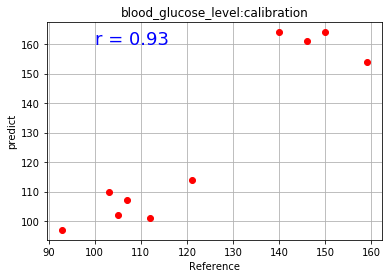

In [32]:
plt.plot(tarr_ref, tarr_pre, 'ro')
plt.grid()
plt.xlabel('Reference')
plt.ylabel('predict')
plt.title('blood_glucose_level:calibration')
plt.text(100,160, 'r = 0.93', fontsize=18, color='b')
plt.savefig('val_result')
plt.show()

# クラス定義の仕方を変えてみる

In [25]:
class MyChain(chainer.Chain):
    def __init__(self):
        super(MyChain, self).__init__(
            l1 = L.Linear(1000, 1000),
            l2 = L.Linear(1000, 1)
        )
    
    def __call__(self, x, t):
        pt = self.fwd(x)
        return F.mean_squared_error
    
    def fwd(self, x):
        h1 = F.relu(self.l1(x))
        return self.l2(h1)
    

# ダメだった…

# 和田さんが昔書いたらしいRegressionクラス
#### どれも失敗で終わりそう…誰か助けて…

In [40]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import link

In [49]:
class Regression_beta2(link.Chain):
    compute_score = True
    
    def __init__(self, net, gpu_enable=-1, acc=0, 
                 lossfun=F.mean_squared_error,
                 scorefun=F.r2_score,):
        super(Regression_beta2, self).__init__()
        self.lossfun = lossfun
        self.scorefun = scorefun
        self.y = None
        self.loss = None
        self.score = None
        with self.init_scope():
            self.net = net
            
    def __call__(self, x, y):
        self.h = None
        self.loss = None
        self.accuracy = None
        self.h = self.net(x)
        self.loss = self.lossfun(self.h, y)
        chainer.reporter.report({'loss': self.loss}, self)
        if self.compute_score:
            self.score = self.scorefun(self.h, y)
            chainer.reporter.report({'score': self.score}, self)
            return self.loss

In [50]:
net = Sequential(
  L.Linear(None, 1000),
  F.relu,
  L.Linear(1000,1)
)

In [52]:
model_B = Regression_beta2(net, 
                    lossfun=F.mean_squared_error,
                     scorefun=F.r2_score)

In [78]:
model_A = L.Classifier(net,
                       lossfun = F.mean_squared_error,
                       accfun=F.r2_score)

In [81]:
x = numpy.random.random((100, 1713)).astype(numpy.float32)   
t = numpy.random.random((100,1)).astype(numpy.float32)  

In [69]:
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

In [70]:
updater = training.updaters.StandardUpdater(x, optimizer)
trainer = training.Trainer(updater, (20, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

In [71]:
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [72]:
trainer.run()

Exception in main training loop: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Traceback (most recent call last):
  File "C:\Users\Owner\Anaconda3\lib\site-packages\chainer\training\trainer.py", line 312, in run
    while not stop_trigger(self):
  File "C:\Users\Owner\Anaconda3\lib\site-packages\chainer\training\triggers\interval_trigger.py", line 51, in __call__
    epoch_detail = updater.epoch_detail
  File "C:\Users\Owner\Anaconda3\lib\site-packages\chainer\training\updaters\standard_updater.py", line 101, in epoch_detail
    return self._iterators['main'].epoch_detail
Will finalize trainer extensions and updater before reraising the exception.


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [76]:
model

# 任意のデータセットを取り出したい

In [58]:
r = len(y_test)

for i in range(r):
    print(y_test[i])


132.0
151.0
153.0
147.0
138.0
136.0
95.0
121.0
120.0
95.0
178.0
175.0
113.0
104.0
131.0
178.0
111.0
137.0
167.0
146.0
111.0
113.0
189.0
131.0
127.0
146.0
169.0
107.0
120.0
122.0
121.0
117.0
141.0


In [59]:
data, teach = easy_chainer.load_Data("C:/Users/Owner/Desktop/Normalized/blood_glucose_fulldata.xlsx")
data = data.astype(numpy.float32)
teach = teach
print(teach)
print(teach.shape)

[ 97.  87. 111.  89.  89. 140. 150. 134. 142. 145. 146. 145. 146. 136.
 143. 159. 133. 147. 158. 143. 146. 142. 139. 137. 138. 140. 138. 146.
 136. 135. 131. 122. 126. 134. 129.  98.  94.  96.  87.  96.  94.  98.
 102.  90.  84.  94.  90. 124. 137. 139. 141. 151. 133. 144. 121. 134.
 139. 136. 122. 116. 125. 109. 111. 112. 111. 116. 105. 115. 117. 128.
 139. 121. 145. 147. 156. 154. 179. 154. 145. 152. 158. 158. 149. 149.
 157. 160. 150. 154. 157. 160. 135. 148. 138. 140. 133. 135. 124. 133.
 134. 120. 114. 117.  91.  97.  98.  98. 109. 109. 119. 117. 118. 132.
 142. 153. 147. 148. 152. 151. 135. 143. 135. 152. 149. 139. 135. 153.
 132. 140. 139. 132. 131. 117. 130. 122. 122. 120. 120.  90.  90.  96.
  89.  89.  95.  96.  87.  99.  86.  96.  88.  91. 101. 168. 158. 153.
 145. 151. 155. 145. 144. 156. 156. 151. 160. 136. 147. 141. 141. 138.
 143. 147. 127. 154. 131. 120. 121. 131. 128. 129. 132. 136. 117. 121.
 117. 120.  88.  95.  99.  98. 107. 113. 113. 131. 121. 116. 137. 122.
 111. 

C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = xls.as_matrix()[:-1]
C:\Users\Owner\Desktop\LAB\LAB 2018\jupyter File\easy_chainer.py:88: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  teach = xls.as_matrix()[-1]


In [60]:
id_train_1 = teach[0:394]
id_test_1 = teach[394:427]

id_train = id_train_1.astype(numpy.int32)
id_test = id_test_1.astype(numpy.int32)

# teach = teach.astype(numpy.float32)

# print("id_train : ", id_train)
print("id_train : ", id_train.shape)
print("id_train_type : ", id_train.dtype)

# print("id_test : ", id_test)
print("id_test : ", id_test.shape)
print("id_test : ", id_test.dtype)

id_train :  (394,)
id_train_type :  int32
id_test :  (33,)
id_test :  int32


In [66]:
teach[0]

97.0

In [71]:
data[:, 0:2]

array([[1.      , 1.      ],
       [0.999609, 0.999732],
       [0.998718, 0.998953],
       ...,
       [0.999004, 1.022624],
       [1.000806, 1.024411],
       [1.00206 , 1.025625]], dtype=float32)

In [78]:
x_train, y_train = data[:, 0:394], teach[0:394]
x_test, y_test = data[:, 394:427], teach[394:427]

In [79]:
train = tuple_dataset.TupleDataset(x_train.T, y_train.reshape(-1,1 ))
test = tuple_dataset.TupleDataset(x_test.T, y_test.reshape(-1, 1))

train_iter = chainer.iterators.SerialIterator(train, 10, repeat=True,  shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, 10, repeat=False, shuffle=False)

In [80]:
net = MLP2(1000,1)
model = L.Classifier(net,
                     lossfun=F.mean_squared_error,
                     accfun = F.r2_score)
model.compute_accuracy = False

In [81]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [82]:
updater = training.updaters.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (5, 'epoch'), out="Result2018_oono/%s" % time.strftime("%Y%m%d%H%M%S"))

In [83]:
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
# frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
# trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

# if args.resume:
#     # Resume from a snapshot
#     chainer.serializers.load_npz(args.resume, trainer)


In [84]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           2892.57     1010.58                                                        5.4546        
2           2372.61     7001.71                                                        11.4489       
     total [#########################.........................] 50.76%
this epoch [##########################........................] 53.81%
       100 iter, 2 epoch / 5 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
3           2540.57     850.967                                                        17.1815       
4           1809.13     1151.42                                                        22.6461       
5           1969.66     3103.86                                                        27.6999       


In [87]:
# 検証（訓練データ）
train_iter.reset()

train_batch = train_iter.next()
train_spc, train_ref = concat_examples(train_batch)  # Test Dataset
for i in range(10):
    cal_ref = train_ref[i]
    cal_pred = net(train_spc[i].reshape(1, -1)).data
    print("%d, %d " % (cal_ref, cal_pred))

97, 199 
87, 198 
111, 193 
89, 196 
89, 201 
140, 201 
150, 194 
134, 191 
142, 197 
145, 202 


In [91]:
# 検証（テストデータ）
#test_iter.reset()

test_batch = test_iter.next()
test_spc, test_ref = concat_examples(test_batch)  # Test Dataset
for i in range(10):
    ref = test_ref[i]
    pred = net(test_spc[i].reshape(1, -1)).data
    print("%d, %d " % (ref, pred))

174, 222 
180, 246 
166, 221 


IndexError: index 3 is out of bounds for axis 0 with size 3